# Homework 3

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from collections import Counter
import sklearn
from scipy.spatial.distance import cdist
import functools
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import itertools

random.seed(27)

### Question 1

$$
\text{Given that } g \in \partial f_k(x) \text{, we know } f_k(z) \geq f_k(x+z) + g^T_{f_k(x)}(z-x)
$$

Now, since $f_k(x) = f(x)$, we can take k to be the index associated to the largest function, which allows us to express the initial expression:

$$
f(z) \geq f(x+z) + g^T_{f(x)}(z-x) \text{, which proves } g \in \partial f(x)
$$

### Question 2

$$
\begin{equation*}
    \begin{split}
        J(w) = max\{0, 1-yw^Tx\} = \begin{cases} 0 \textbf{ if } yw^Tx\geq1\\1-yw^Tx \textbf{ if } yw^Tx<1\end{cases}= \begin{cases} 0 \textbf{ if } yw^Tx\geq1\\-yx \textbf{ if } yw^Tx<1\end{cases}\\
    \end{split}
\end{equation*}
$$

### Question 3

A function is convex if for all $x, y$ in the domain of $f$ for all $\theta \in (0,1)$:
$$
\begin{equation*}
    \begin{split}
        \theta f(a) + (1-\theta)f(b) \geq f(\theta a + (1-\theta)(b))
    \end{split}
\end{equation*}
$$

Let's suppose that f is not convex. <br>
Then, there is a point $x_0$ in some interval $x \in (a,b)$, such that $f(x_0)$ lies above $\theta f(a) + (1-\theta)f(b)$.

### Question 4

$\partial J(w)$ is undefined when $y_iw^Tx_i = 1$ and defined everywhere else.

$$
\begin{equation*}
    \begin{split}
        J(w) = \begin{cases} \frac{\lambda}{2}||w||^2 \textbf{ if } yw^Tx>1\\ \frac{\lambda}{2}||w||^2 + (1-yw^Tx) \textbf{ if } yw^Tx<1\end{cases} \rightarrow \begin{cases} \lambda w \textbf{ if } yw^Tx>1\\ \lambda w - yx \textbf{ if } yw^Tx<1\end{cases} 
    \end{split}
\end{equation*}
$$


### Question 5

$$
\begin{equation*}
    \begin{split}
        J(w) = \frac{\lambda}{2}||w||^2 + max\{0, 1-yw^Tx\} = \begin{cases} \frac{\lambda}{2}||w||^2 \textbf{ if } yw^Tx\geq1\\ \frac{\lambda}{2}||w||^2 + (1-yw^Tx) \textbf{ if } yw^Tx<1\end{cases}
    \end{split}
\end{equation*}
$$

Now, let's differentiate.

$$
\begin{equation*}
    \begin{split}
        \begin{cases} \frac{\lambda}{2}||w||^2 \\ \frac{\lambda}{2}||w||^2 + (1-yw^Tx)\end{cases}\rightarrow \begin{cases} \lambda w \textbf{ if } yw^Tx\geq1\\ \lambda w -yx \textbf{ if } yw^Tx<1\end{cases}
    \end{split}
\end{equation*}
$$

### Given code (SVM with Pegasos algorithm)

In [2]:
def read_data(file):
    '''
    Read each file into a list of strings.
    '''
    f = open(file)
    lines = f.read().split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip(), lines)
    words = filter(None, words)
    return list(words)

In [3]:
def folder_list(path,label):
    '''
    PARAMETER PATH IS THE PATH OF YOUR LOCAL FOLDER
    '''
    filelist = os.listdir(path)
    review = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data(file)
        r.append(label)
        review.append(r)
    return review

In [6]:
def load_and_shuffle_data():
    '''
    pos_path is where you save positive review data.
    neg_path is where you save negative review data.
    '''
    pos_path = "data_reviews/data/pos"
    neg_path = "data_reviews/data/neg"
    
    pos_review = folder_list(pos_path,1)
    neg_review = folder_list(neg_path,-1)

    review = pos_review + neg_review
    random.shuffle(review)
    return review

In [7]:
# Taken from http://web.stanford.edu/class/cs221/ Assignment #2 Support Code
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

In [8]:
def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale


### Question 6

In [9]:
def bag_of_words(input_):
    return Counter(input_)

### Question 7

In [10]:
review = load_and_shuffle_data()

In [11]:
X_train, X_test, y_train, y_test = [], [], [], []

for doc in review[0:1500]:
    X_train.append(bag_of_words(doc[0:-1])) #Read all words except the label
    y_train.append(doc[-1]) #Read the label
    
for doc in review[1500:2000]:
    X_test.append(bag_of_words(doc[0:-1])) #Read all words except the label
    y_test.append(doc[-1]) #Read the label

### Question 8

In [12]:
def pegasos(X_train, y_train, epochs = 3, lbd=0.01):
    
    t, w = 1, {}

    for _ in range(epochs):
        for idx in range(0, len(X_train)):
            t += 1
            step = 1/(t*lbd)

            #Update w regardless of the training point
            for key, value in w.items():
                w[key] = value * (1-step*lbd)

            if y_train[idx] * dotProduct(w, X_train[idx]) < 1:
                increment(w, step * y_train[idx], X_train[idx])
                
    return w 

### Question 9

The initial update rule is:
$$
w_{t+1} = (1-\eta_t \lambda)w_t + \eta_ty_jx_j
$$

Let's verify that it is equal to:
$$
s_{t+1} = (1-\eta_t\lambda)s_t \text{ and } w=sW\\
W_{t+1} = W_t + \frac{1}{s_{t+1}}\eta_ty_jx_j
$$

Proof:
$$
\begin{equation*}
    \begin{split}
        w_{t+1} =\\
&= s_{t+1}W_{t+1} \\
&= (1-\eta_t\lambda)s_t(W_t + \frac{1}{(1 \eta_t\lambda)s_t}\eta_ty_jx_j) \\
&= (1-\eta_t\lambda)s_tW_t + \eta_ty_jx_j\\
&= (1-\eta_t\lambda)w_t + \eta_ty_jx_j
    \end{split}
\end{equation*}
$$

In [13]:
def optimized_pegasos(X_train, y_train, epochs = 3, lbd=0.01):
         
    s, t, w = 1, 1, {}
    for _ in range(epochs):
        for idx in range(0, len(X_train)):
            t += 1
            step = 1/(t*lbd)
            s *= (1-step*lbd) #Update s regardless of the training point

            if y_train[idx] * dotProduct(w, X_train[idx]) * s < 1:
                increment(w, (1/s) * step * y_train[idx], X_train[idx])
    for key, value in w.items():
        w[key] = value * s
            
    return w

### Question 10

In [14]:
%%time
w = pegasos(X_train, y_train, epochs=3, lbd=0.01)

Wall time: 14.1 s


In [15]:
%%time
w = optimized_pegasos(X_train, y_train, epochs=3, lbd=0.01)

Wall time: 322 ms


The first method takes around 15 seconds, whereas the second method takes 0.3 seconds.

### Question 11

In [12]:
def classification_error(X, y, w):

    count = 0
    for idx in range(len(X)):
        pred = dotProduct(w, X[idx])
    
        if pred * y[idx] < 0:
            count += 1
    return round(count/len(X),3)

### Question 12

In [18]:
lambda_list = [10**-3, 0.01, 0.05, 0.1, 0.12, 0.5, 1]
error_list = []
    
for lbd in lambda_list:
    w = optimized_pegasos(X_train, y_train, epochs=50, lbd=lbd)
    error_list.append(classification_error(X_test, y_test, w))

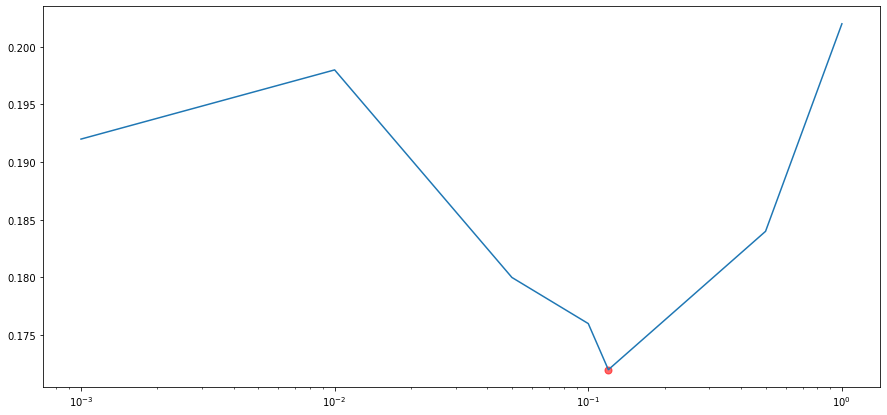

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(lambda_list, error_list)
plt.scatter(lambda_list[np.argmin(error_list)], np.min(error_list), color='red', s=50, alpha=0.6)
plt.xscale('log')
plt.show()

In [13]:
opt_lambda = 0.12

In [25]:
pd.DataFrame({'lambda': lambda_list, 'error': error_list})

,lambda,error
0,0.001,0.192
1,0.010,0.198
2,0.050,0.180
3,0.100,0.176
4,0.120,0.172
5,0.500,0.184
6,1.000,0.202


### Question 13

In [297]:
w = optimized_pegasos(X_train, y_train, epochs=10, lbd=opt_lambda)

score_list = []
for idx in range(len(X_test)):
        score_list.append(dotProduct(w, X_test[idx]))

In [300]:
score_dict = {}
score_dict["below -2"] = [(score, label) for score, label in zip(score_list, y_test) if score <= -2]
score_dict["-2 to 0"] = [(score, label) for score, label in zip(score_list, y_test) if (score < 0) & (score > -2)]
score_dict["0 to 2"] = [(score, label) for score, label in zip(score_list, y_test) if (score > 0) & (score < 2)]
score_dict["above 2"] = [(score, label) for score, label in zip(score_list, y_test) if score >= 2]

In [310]:
margin_dict = {}
margin_dict["below -2"] = [1 if score*label < 0 else 0 for score, label in score_dict["below -2"]]
margin_dict["-2 to 0"] = [1 if score*label < 0 else 0 for score, label in score_dict["-2 to 0"]]
margin_dict["0 to 2"] = [1 if score*label < 0 else 0 for score, label in score_dict["0 to 2"]]
margin_dict["above 2"] = [1 if score*label < 0 else 0 for score, label in score_dict["above 2"]]

In [321]:
rows = []
for key, value in margin_dict.items():
     rows.append([key, len(value), np.sum(value), len(value)-np.sum(value), round((len(value)-np.sum(value))/len(value), 3)])
        
df = pd.DataFrame(rows, columns=["Range", "Total", "Correct", "Incorrect", "Classification error"])
df.set_index("Range")

,Total,Correct,Incorrect,Classification error
Range,,,,
below -2,106,5,101,0.953
-2 to 0,167,53,114,0.683
0 to 2,147,33,114,0.776
above 2,80,2,78,0.975


It is clear that the algorithm has much more confidence in its prediction when the score is higher than 2 for positive predictions and lower than -2 for negative predictions.

### Question 14

Let's take a look at the first few document scores.

In [78]:
w = optimized_pegasos(X_train, y_train, epochs=10, lbd=opt_lambda)

score_list = []
for idx in range(len(X_test)):
        score_list.append(["Document " + str(idx+1), round(y_test[idx] * dotProduct(w, X_test[idx]), 3)])

In [68]:
score_list[:5]

[['Document 1', -0.451],
 ['Document 2', -0.78],
 ['Document 3', 2.325],
 ['Document 4', -0.008],
 ['Document 5', 1.544]]

Let's analyze the first one (which was incorrectly classified), the 480th document (which has the highest confidence among the incorrectly classified documents) and, as a contrast, the 465th document (which is correctly classified and has the highest confidence).

In [70]:
def missclassification_analysis(idx):
    dict_ = {}
    
    print("Confidence of the missclassification: ", round(y_test[idx] * dotProduct(w, X_test[idx]), 3))
    
    for word in X_test[idx].keys():
        if word in w.keys():
            dict_[word] = abs(w[word] * X_test[idx][word])
    
    return pd.DataFrame.from_dict({'contribution':dict_}).sort_values(by='contribution', ascending=False)

In [74]:
df_0 = missclassification_analysis(0)
df_0.head(10)

Confidence of the missclassification:  -0.451


,contribution
and,1.155479
is,0.999933
the,0.992156
to,0.400529
movie,0.378864
on,0.375531
even,0.359976
only,0.328867
war,0.322201
he,0.319423


In [75]:
df_480 = missclassification_analysis(480)
df_480.head(10)

Confidence of the missclassification:  -3.834


,contribution
to,1.029931
the,0.809390
he,0.702731
into,0.599960
and,0.577739
is,0.549963
have,0.466636
funny,0.380530
on,0.375531
any,0.333311


In [92]:
df_465 = missclassification_analysis(465)
df_465.head(10)

Confidence of the missclassification:  11.073


,contribution
bad,1.971535
to,1.602115
why,1.199920
on,1.126592
is,1.049930
the,1.018265
and,0.933271
as,0.844388
nothing,0.759949
any,0.666622


After looking at the features that contributed the most to the classification of each document, it is clear that the wrongly classified documents have non-essential words (stopwords) as the highest contribution features, which do not reflect the true meaning of the document. On the other hand we can see that the correctly classified document has meaningful words such as bad or nothing as the top contributing features. 

To fix this we could could remove all stopwords, so that only the more unique words contribute towards the score of a document. Regarding the addition of a new feature, it would also be a good idea to create 2-gram or 3-gram words, which consist of combinations of words which would help clarify the meaning behind words such as "not bad", which really means good.

### Question 15

To obtain the value for w that minimizes this expression we have to derive it with respect to w and equal it to 0.

$$
\begin{equation*}
    \begin{split}
J(w) = ||Xw-y||^2 + \lambda||w||^2 = w^tX^TXw-2w^TX^Ty+\lambda w^Tw
    \end{split}
\end{equation*}
$$

$$
\begin{equation*}
    \begin{split}
\frac{\partial J(w)}{\partial w} = 0\\
&\rightarrow 2X^TXw-2X^Ty+2\lambda Iw = 0 \\
&\rightarrow X^Ty = X^TXw+\lambda Iw\\
&\rightarrow w=(X^TX+\lambda I)^{-1}X^Ty
    \end{split}
\end{equation*}
$$

Now, let's prove that $(X^TX+\lambda I)^{-1}$ exists by proving that the matrix $X^TX+\lambda I$ is Positive Definite and therefore invertible.

$$
\begin{equation*}
    \begin{split}
z^TMz\geq 0 \\
&\rightarrow z^TX^TXz \geq 0\\
&\rightarrow (Xz)^T(Xz) \geq 0\\
&\rightarrow ||Xz||^2 \geq 0\\
    \end{split}
\end{equation*}
$$

In this proof we can see that any symmetric matrix ($X^TX$) is Positive semi-Definite.
Meaning that all its eigenvalues are non-negative.

Using the eigenvalue-eigenvector properties: $X^TXv = \lambda v$

$$
\begin{array}{rl}X^TXv &= (X^TX + c I)v \\ &= X^TXv + c I v \\ &= \lambda v + c v \\ &= (\lambda + c)v\end{array}
$$

In this last proof, $\lambda$ represents the eigenvalues of $X^TX$ and c represents the constant $\lambda$ of the question.<br>
As a consequence, the condition $λ > 0$ (or $c$ > 0) is sufficient to
guarantee that $XT X + λI$ is Positive Definite.

### Question 16

$$
\begin{equation*}
    \begin{split}
        \lambda X^TXw + \lambda Iw = X^Ty \rightarrow \lambda Iw = X^Ty-X^TXw  \rightarrow w = \frac{1}{\lambda}(X^Ty-X^TXw)\\
    \end{split}
\end{equation*}
$$

Which can then be rewritten as:

$$
\begin{equation*}
    \begin{split}
        w = \frac{1}{\lambda}(X^Ty-X^TXw) \rightarrow w=X^T(\frac{1}{\lambda}y - \frac{1}{\lambda}Xw) \rightarrow w = X^T \alpha
    \end{split}
\end{equation*}
$$

### Question 17

Because we can see that $w$ is a linear combination of our input data $X$ (where the coefficients are the resulting vector $\alpha$)

### Question 18

$$
\begin{equation*}
    \begin{split}
        \alpha = \frac{1}{\lambda}(y-Xw) \\
        &\rightarrow \alpha = \frac{1}{\lambda}(y-XX^T\alpha)\\
        &\rightarrow \lambda\alpha + XX^T\alpha = y\\
        &\rightarrow (\lambda I + XX^T)\alpha = y\\
        &\rightarrow \alpha = (\lambda I + XX^T)^{-1}y\\
    \end{split}
\end{equation*}
$$

### Question 19

$$
\begin{equation*}
    \begin{split}
        Xw =\\
        &= X(X^T\alpha)\\
        &= X(X^T(\lambda I + XX^T)^{-1}y)\\
        &= XX^T(\lambda I + XX^T)^{-1}y\\
    \end{split}
\end{equation*}
$$

### Question 20

$$
\begin{equation*}
    \begin{split}
        f(x) = x^Tw\\
        &= x^T(X^T\alpha)\\
        &= \sum_{i} \alpha_i \langle x^T, x_i \rangle \\
        &= \sum_{i} \alpha_i k_x\\
    \end{split}
\end{equation*}
$$

### Question 21

In [281]:
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))

In [15]:
def RBF_kernel(X1,X2,sigma=1):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    numerator = cdist(X1,X2,'sqeuclidean')
    denominator = 2 * sigma**2
    return np.exp(-numerator / denominator)

In [117]:
def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    return (offset + X1 @ X2.T)**degree

### Question 22

In [130]:
x_0 = np.array([[-4], [-1], [0], [2]])

linear_kernel(x_0, x_0)

array([[16,  4,  0, -8],
       [ 4,  1,  0, -2],
       [ 0,  0,  0,  0],
       [-8, -2,  0,  4]])

### Question 23

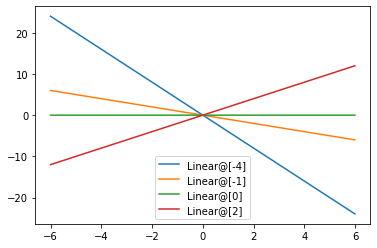

In [282]:
# PLot kernel machine functions

plot_step = .01
xpts = np.arange(-6, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
y = linear_kernel(prototypes, xpts) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show() 

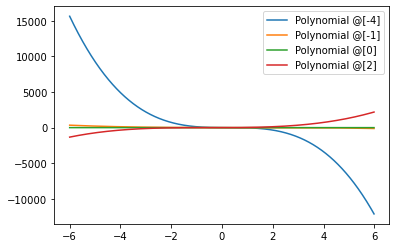

In [120]:
# Polynomial kernel
y = polynomial_kernel(prototypes, xpts, offset=1, degree=3) 
for i in range(len(prototypes)):
    label = "Polynomial @"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show() 

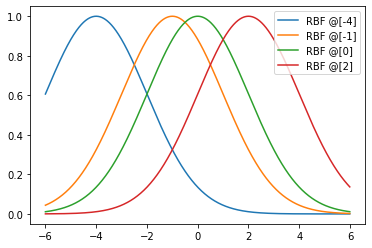

In [199]:
# RBF kernel
y = RBF_kernel(prototypes, xpts, sigma=1) 
for i in range(len(prototypes)):
    label = "RBF @"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show() 

### Question 24

In [99]:
class Kernel_Machine(object):
    def __init__(self, kernel, training_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            training_points - an nxd matrix with rows x_1,..., x_n
            weights - a vector of length n with entries alpha_1,...,alpha_n
        """

        self.kernel = kernel
        self.training_points = training_points
        self.weights = weights

    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R alpha_i k(x_j, mu_i)
        """
        return self.kernel(X, self.training_points) @ self.weights

In [96]:
prototype = np.array([-1, 0, 1]).reshape(-1, 1)
weights = np.array([1, -1, 1])
x = np.array([-4, -1, 0, 2]).reshape(-1,1)

k = functools.partial(RBF_kernel, sigma=1)

kernel_machine = Kernel_Machine(k, prototype, weights)

In [97]:
kernel_machine.predict(x)

array([0.01077726, 0.52880462, 0.21306132, 0.48230437])

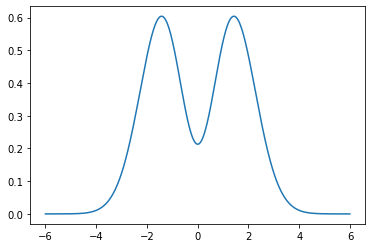

In [98]:
plot_step = .01
xpts = np.arange(-6, 6, plot_step).reshape(-1,1)

y = kernel_machine.predict(xpts)

plt.plot(xpts, y)
plt.show() 

### Question 25

In [294]:
data_train,data_test = np.loadtxt("krr-train.txt"),np.loadtxt("krr-test.txt")

x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

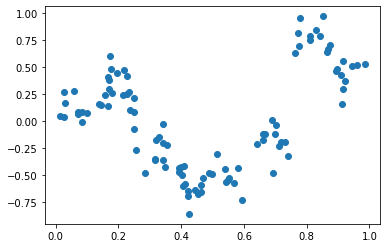

In [295]:
plt.scatter(x_train, y_train)
plt.show()

### Question 26

In [298]:
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    
    alpha = np.linalg.inv(l2reg * np.identity(len(X)) + kernel(X, X)) @ y
    
    return Kernel_Machine(kernel, X, alpha)

### Question 27

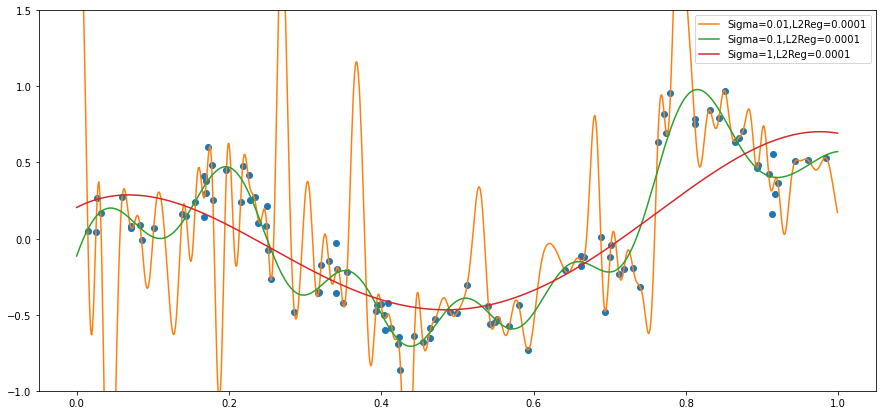

In [143]:
plt.figure(figsize=(15, 7))
plot_step = .001
xpts = np.arange(0, 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
l2reg = 0.0001
for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

The smaller $\sigma$ is, the smaller the period is and therefore the higher the volatilidy, which causes the overfitting. On the other hand, the higher $\sigma$ is, the larger the period and therefore it ends up underfitting.

### Question 28

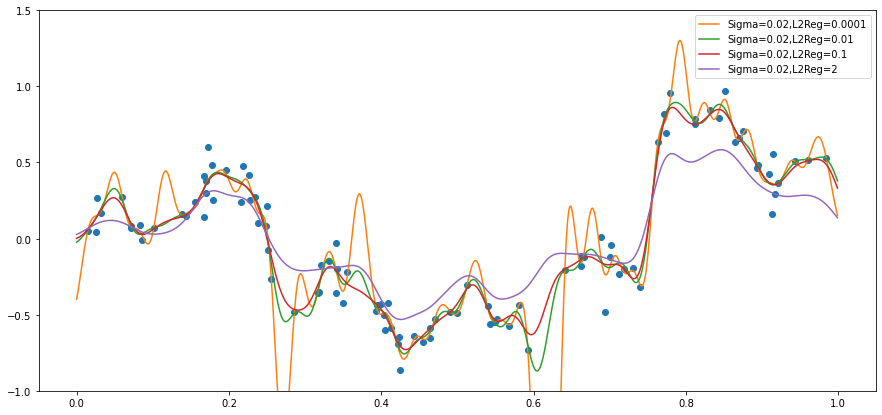

In [153]:
plt.figure(figsize=(15, 7))
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
sigma= .02
for l2reg in [.0001,.01,.1,2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

As $\lambda$ grows, the more regularization is applied and it ends up setting all weights to 0 and predicting the line y=0 (under-fitting)

### Question 29

In [155]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelRidgeRegression(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return(((self.predict(X)-y)**2).mean()) 

In [158]:
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [310]:
param_grid = [{'kernel': ['RBF'],'sigma':[0.05, 0.055, 0.06], 'l2reg': [0.271, 0.27, 0.269]},
              {'kernel':['polynomial'],'offset':[1.75, 1.8, 1.85], 'degree':[5, 6, 7],'l2reg':[0.033, 0.034, 0.035]},
              {'kernel':['linear'],'l2reg': [3.2, 4, 4.5]}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False),
                    return_train_score=True
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KernelRidgeRegression(),
             param_grid=[{'kernel': ['RBF'], 'l2reg': [0.271, 0.27, 0.269],
                          'sigma': [0.05, 0.055, 0.06]},
                         {'degree': [5, 6, 7], 'kernel': ['polynomial'],
                          'l2reg': [0.033, 0.034, 0.035],
                          'offset': [1.75, 1.8, 1.85]},
                         {'kernel': ['linear'], 'l2reg': [3.2, 4, 4.5]}],
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [313]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
1,-,RBF,0.271,-,0.055,0.013821,0.014350
4,-,RBF,0.270,-,0.055,0.013821,0.014343
7,-,RBF,0.269,-,0.055,0.013821,0.014336
8,-,RBF,0.269,-,0.06,0.013979,0.015268
5,-,RBF,0.270,-,0.06,0.013982,0.015276
...,...,...,...,...,...,...,...
12,5,polynomial,0.034,1.75,-,0.046631,0.073522
15,5,polynomial,0.035,1.75,-,0.046974,0.073954
37,-,linear,4.000,-,-,0.164510,0.206563
38,-,linear,4.500,-,-,0.164511,0.206577


**Best Parameters**

RBF (0.01321)
* sigma=0.055
* l2reg = 0.27

POLY (0.032405)
* degree=6 
* l2reg=0.034
* offset=1.8

Lin (0.16451)
* l2reg = 4

### Question 30

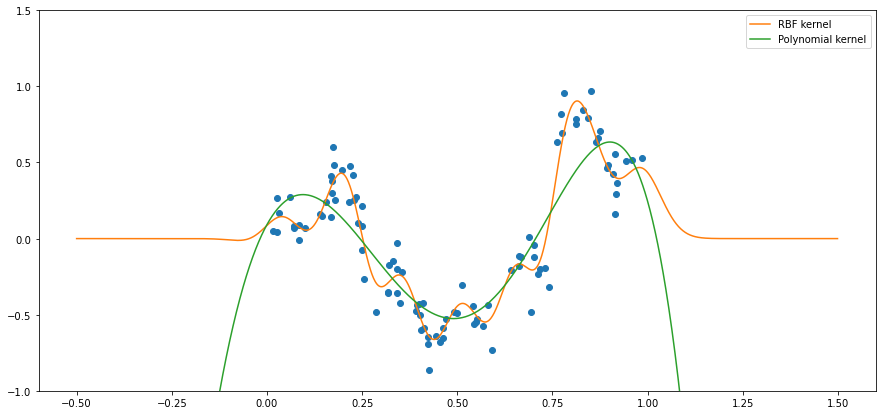

In [299]:
plt.figure(figsize=(15, 7))

sigma, l2reg_rbf = 0.055, 0.27
degree, l2reg_poly, offset = 6, 0.034, 1.8

k_rgb = functools.partial(RBF_kernel, sigma=sigma)
k_poly = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f_rbg = train_kernel_ridge_regression(x_train, y_train, k_rgb, l2reg=l2reg_rbf)
f_poly = train_kernel_ridge_regression(x_train, y_train, k_poly, l2reg=l2reg_poly)

xpts = np.arange(-0.5 , 1.5, .001).reshape(-1,1)
plt.plot(x_train,y_train,'o')
plt.plot(xpts, f_rbg.predict(xpts), label='RBF kernel')
plt.plot(xpts, f_poly.predict(xpts), label='Polynomial kernel')
plt.ylim(-1,1.5)
plt.legend()
plt.show()

We can see that the RGB kernel model is more volatile than the polynomial kernel which helps it get a better test score.

The polynomial kernel model seems to capture the pattern in a more general way which translates to a slightly worse test score.

### Question 31

The Bayes decision function is $f(x) + E(\epsilon)$, where $E(\epsilon) = 0$, therefore it is just the true underlying function f(x).

The Bayes risk on the other hand is:

$$
E[l(\hat{y}-y)] = E[(\hat{y}-y)^2] = E[(g(x)-(f(x)-\epsilon))^2] = E[\epsilon^2] = Var(\epsilon) = 0.1^2
$$

### Question 32

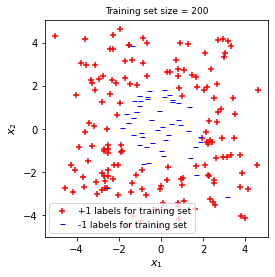

In [63]:
# Load and plot the SVM data
#load the training and test sets
data_train,data_test = np.loadtxt("svm-train.txt"),np.loadtxt("svm-test.txt")
x_train, y_train = data_train[:,0:2], data_train[:,2].reshape(-1,1)
x_test, y_test = data_test[:,0:2], data_test[:,2].reshape(-1,1)

#determine predictions for the training set
yplus = np.ma.masked_where(y_train[:,0]<=0, y_train[:,0])
xplus = x_train[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_train[:,0]>0, y_train[:,0])
xminus = x_train[~np.array(yminus.mask)]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

The data is not linearly separable but it is quadratically separable. This is similar to the example in class, if a quadratic dimension is added, a plane can be found that separates the data (whose intersection with the data translates into a circle in 2 dimensions). Using the RBF kernel, the model can achieve a decision boundary that approximates a complex ellipsoid, which could also approximate the data very well.

### Question 33

In [214]:
def train_soft_svm(X_train, y_train, kernel, epochs = 3, lbd=0.01):
    
    t, a = 1, np.ones(len(X_train))

    for _ in range(epochs):
        for idx in range(len(X_train)):
            t += 1
            a *= (1-1/t)

            if y_train[idx] * kernel(X_train[idx].reshape(1,2), X_train) @ a < 1:
                a[idx] += 1 * y_train[idx] / (lbd*t)
                
    return a 

In [215]:
def check_score(y_test, pred):
    count = 0
    for i in range(len(y_test)):
        if y_test[i] * pred[i] > 0:
            count += 1

    return 100 * count/len(y_test)

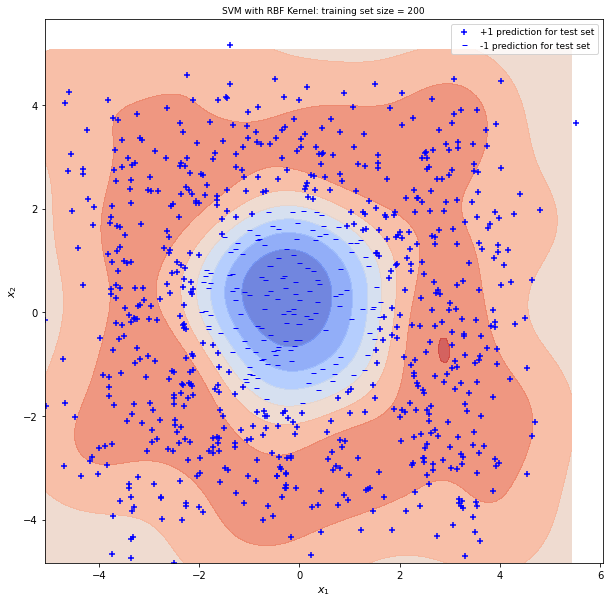

In [216]:
# Code to help plot the decision regions
# (Note: This code isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
 
sigma=1
k = functools.partial(RBF_kernel, sigma=sigma)
alpha = train_soft_svm(x_train, y_train, k)
f = Kernel_Machine(k, x_train, alpha)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = f.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
f, (ax) = plt.subplots(1, 1, figsize=(10,10)) 
decision =ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [207]:
check_score(y_test, y_bar)

93.125

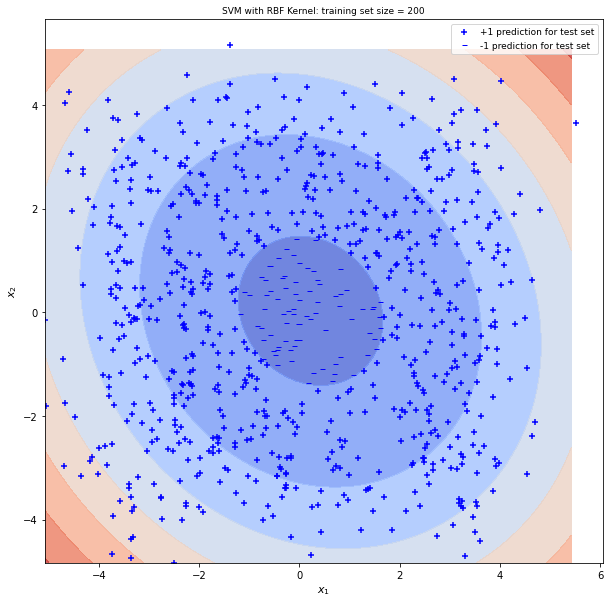

In [217]:
# Code to help plot the decision regions
# (Note: This code isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
 
degree, offset = 2, 1
k = functools.partial(polynomial_kernel, degree=degree, offset=offset)
alpha = train_soft_svm(x_train, y_train, k)
f = Kernel_Machine(k, x_train, alpha)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = f.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
f, (ax) = plt.subplots(1, 1, figsize=(10,10)) 
decision = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

In [218]:
check_score(y_test, y_bar)

88.0

### Question 34

In [253]:
param_grid = {'sigma':[0.295, 0.3, 0.305], 'l2reg': [0.35, 0.4, 0.45]} 
result = {'sigma':[], 'l2reg':[], 'score':[]}

for sigma, l2reg in itertools.product(param_grid['sigma'], param_grid['l2reg']):
    k = functools.partial(RBF_kernel, sigma=sigma)
    alpha = train_soft_svm(x_train, y_train, k, lbd=l2reg)
    f = Kernel_Machine(k, x_train, alpha)
    y_bar = f.predict(x_test) 
    result['sigma'].append(sigma)
    result['l2reg'].append(l2reg)
    result['score'].append(check_score(y_test, y_bar))

pd.DataFrame.from_dict(result)

,sigma,l2reg,score
0,0.295,0.35,94.875
1,0.295,0.40,94.875
2,0.295,0.45,94.750
3,0.300,0.35,94.875
4,0.300,0.40,94.875
5,0.300,0.45,94.875
6,0.305,0.35,94.875
7,0.305,0.40,95.000
8,0.305,0.45,94.875


The best score is 95% (sigma=0.305, l2reg=0.4)

In [279]:
param_grid = {'offset':[1.345, 1.35, 1.375], 'degree': [2], 'l2reg': [0.0275, 0.03, 0.0325]} 
result = {'offset':[], 'degree':[], 'l2reg':[], 'score':[]}

for offset, degree, l2reg in itertools.product(param_grid['offset'], param_grid['degree'], param_grid['l2reg']):
    k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
    alpha = train_soft_svm(x_train, y_train, k, lbd=l2reg)
    f = Kernel_Machine(k, x_train, alpha)
    y_bar = f.predict(x_test) 
    result['offset'].append(offset)
    result['degree'].append(degree)
    result['l2reg'].append(l2reg)
    result['score'].append(check_score(y_test, y_bar))

pd.DataFrame.from_dict(result)

,offset,degree,l2reg,score
0,1.345,2,0.0275,89.250
1,1.345,2,0.0300,95.000
2,1.345,2,0.0325,90.125
3,1.350,2,0.0275,89.250
4,1.350,2,0.0300,95.125
5,1.350,2,0.0325,90.125
6,1.375,2,0.0275,92.625
7,1.375,2,0.0300,91.625
8,1.375,2,0.0325,90.875


The best score is 95.125% (degree=2, offset=1.35, l2reg=0.03)

In [287]:
param_grid = {'l2reg': [0.1, 0.5, 0.75, 1, 1.5, 2]} 
result = {'l2reg':[], 'score':[]}

for l2reg in param_grid['l2reg']:
    k = functools.partial(linear_kernel)
    alpha = train_soft_svm(x_train, y_train, k, lbd=l2reg)
    f = Kernel_Machine(k, x_train, alpha)
    y_bar = f.predict(x_test) 
    result['l2reg'].append(l2reg)
    result['score'].append(check_score(y_test, y_bar))

pd.DataFrame.from_dict(result)

,l2reg,score
0,0.10,49.875
1,0.50,49.625
2,0.75,49.750
3,1.00,49.875
4,1.50,50.000
5,2.00,50.500


The best score is 50% (because the data is not linearly separable)

### Question 35

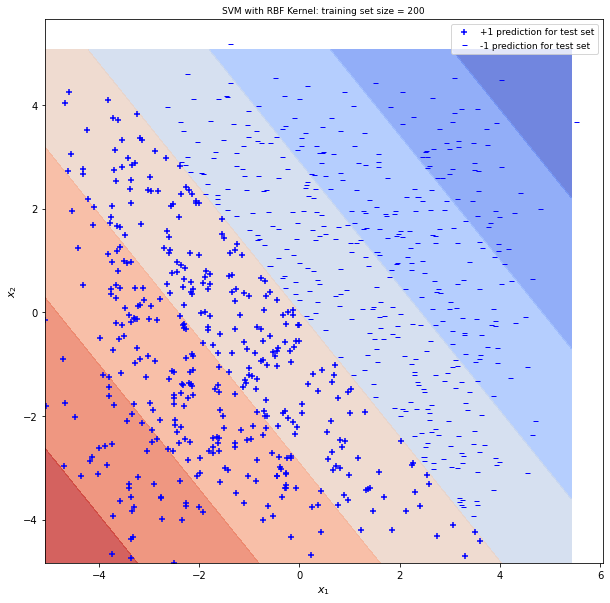

In [289]:
# Code to help plot the decision regions
# (Note: This code isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
l2reg = 1
k = functools.partial(linear_kernel)
alpha = train_soft_svm(x_train, y_train, k, lbd=l2reg)
f = Kernel_Machine(k, x_train, alpha)

x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = f.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
f, (ax) = plt.subplots(1, 1, figsize=(10,10)) 
decision = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

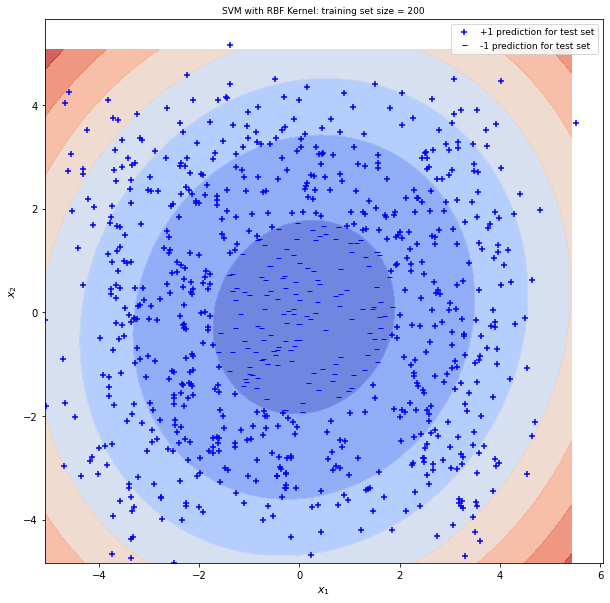

In [290]:
# Code to help plot the decision regions
# (Note: This code isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
 
degree, offset, l2reg = 2, 1.35, 0.03
k = functools.partial(polynomial_kernel, degree=degree, offset=offset)
alpha = train_soft_svm(x_train, y_train, k, lbd=l2reg)
f = Kernel_Machine(k, x_train, alpha)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = f.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
f, (ax) = plt.subplots(1, 1, figsize=(10,10)) 
decision = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

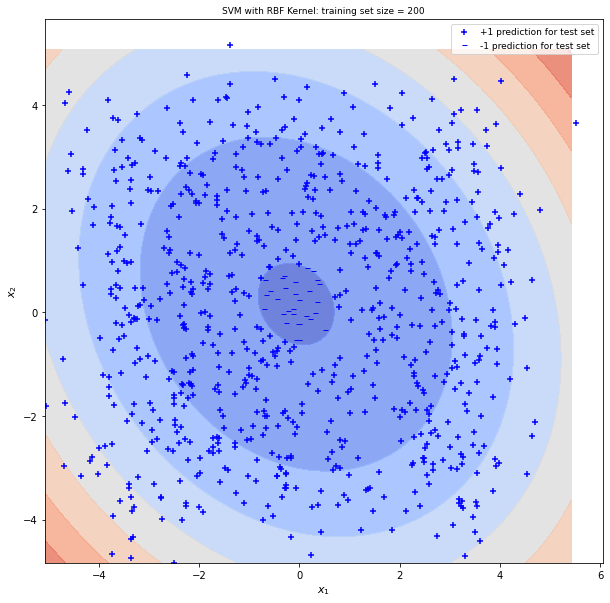

In [291]:
# Code to help plot the decision regions
# (Note: This code isn't necessarily entirely appropriate for the questions asked. So think about what you are doing.)
 
sigma, l2reg = 0.305, 0.4
k = functools.partial(polynomial_kernel, degree=degree, offset=offset)
alpha = train_soft_svm(x_train, y_train, k, lbd=l2reg)
f = Kernel_Machine(k, x_train, alpha)

#determine the decision regions for the predictions
x1_min = min(x_test[:,0])
x1_max= max(x_test[:,0])
x2_min = min(x_test[:,1])
x2_max= max(x_test[:,1])
h=0.1
xx, yy = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))

Z = f.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

#determine the predictions for the test set
y_bar = f.predict (x_test) 
yplus = np.ma.masked_where(y_bar<=0, y_bar)
xplus = x_test[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_bar>0, y_bar)
xminus = x_test[~np.array(yminus.mask)]

#plot the learned boundary and the predictions for the test set
f, (ax) = plt.subplots(1, 1, figsize=(10,10)) 
decision = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='b', label = '+1 prediction for test set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 prediction for test set')
ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('SVM with RBF Kernel: training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()